In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#nn
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA

# RMSE function
def myrmse(y, yhat):
    rmse = np.sqrt(np.sum((y - yhat) ** 2) / len(y))
    return np.round(rmse, 3)


# Constants
num_velocity_lines = 16384
block_size = num_velocity_lines + 5  # total lines per time step

filename = 'Alldata.txt'

X_list = []
y_list = []

with open(filename, 'r') as f:
    lines = f.readlines()

num_blocks = len(lines) // block_size
print(f"Detected {num_blocks} time steps")

for i in range(num_blocks):
    start = i * block_size
    vel_lines = lines[start : start + num_velocity_lines]
    y_line = lines[start + block_size - 1]  # line N+5 = last line of the block

    try:
        # Just grab the third value from each velocity line (no strict header checking)
        velocities = [float(line.strip().split()[-1]) for line in vel_lines]
        
        if len(velocities) != num_velocity_lines:
            raise ValueError(f"Incomplete velocity data in block {i}")

        # Extract Y (wall shear stress) — last value in final line
        y_value = float(y_line.strip().split()[-1])

        X_list.append(velocities)
        y_list.append(y_value)

    except Exception as e:
        print(f"Skipping time step {i} due to error: {e}")
        continue

# Convert to arrays
X = np.array(X_list)
y = np.array(y_list)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Last time value
last_block_start = (len(X_list) - 1) * block_size
last_time_line = lines[last_block_start].strip().split()
last_time = float(last_time_line[-2])
print(f"Last time value: {last_time}")

# === Train-test split ===
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=88)

# === Scale features ===
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)



Detected 137 time steps
X shape: (137, 16384)
y shape: (137,)
Last time value: 396.1692094825463


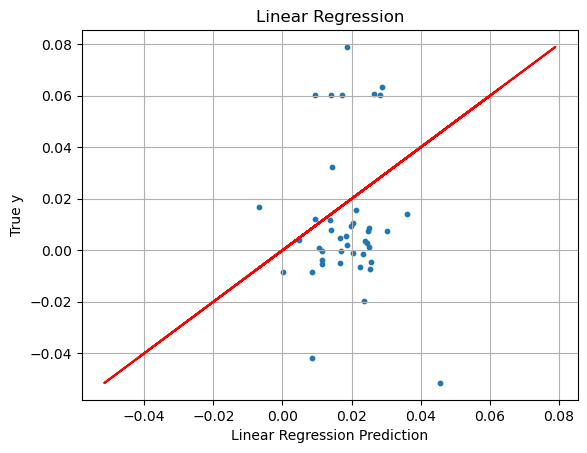

Linear Regression RMSE: 0.03
            ytest   ypredLR
ytest    1.000000 -0.029577
ypredLR -0.029577  1.000000


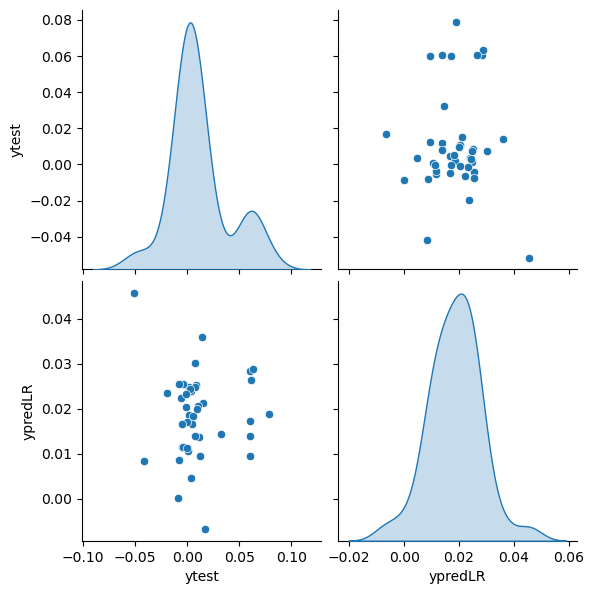

In [53]:
# === Linear Regression ===
linreg = LinearRegression()
linreg.fit(Xtrain, ytrain)
ypredLR = linreg.predict(Xtest)

plt.scatter(ypredLR, ytest, s=10)
plt.plot(ytest, ytest, c='red')
plt.xlabel('Linear Regression Prediction')
plt.ylabel('True y')
plt.title('Linear Regression')
plt.grid(True)
#plt.savefig("LinearRegression.png", dpi=300)
plt.show()

print(f'Linear Regression RMSE: {myrmse(ypredLR, ytest)}')

ypredDF_LR = pd.DataFrame({'ytest':ytest,'ypredLR':ypredLR})
print(ypredDF_LR.corr())

import seaborn as sns
sns.pairplot(ypredDF_LR,diag_kind='kde',height=3)
plt.savefig("LinearRegression_comparison.png", dpi=300)


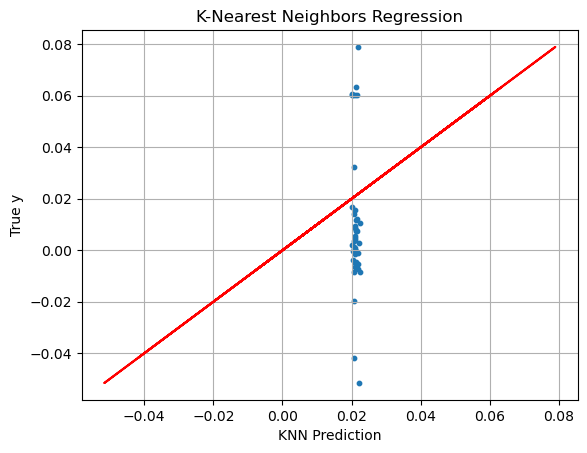

KNN Regression RMSE: 0.029


In [39]:
# === K-Nearest Neighbors Regressor ===
knn = KNeighborsRegressor(n_neighbors=40)  # You can tune this
knn.fit(Xtrain, ytrain)
ypredKNN = knn.predict(Xtest)

plt.scatter(ypredKNN, ytest, s=10)
plt.plot(ytest, ytest, c='red')
plt.xlabel('KNN Prediction')
plt.ylabel('True y')
plt.title('K-Nearest Neighbors Regression')
plt.grid(True)
plt.savefig("KNN_n40.png", dpi=300)
plt.show()

print(f'KNN Regression RMSE: {myrmse(ypredKNN, ytest)}')

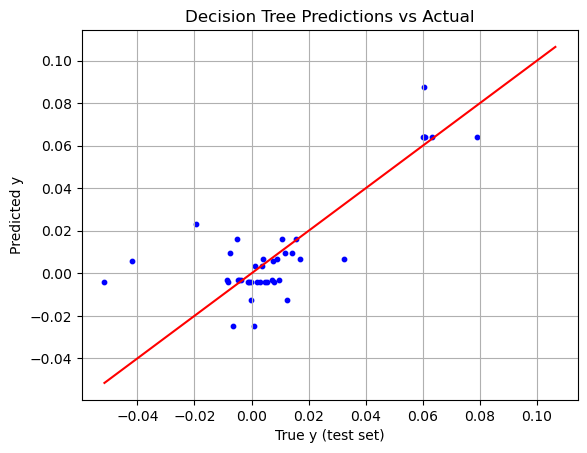

Number of unique predicted values (leaf nodes): 12
RMSE for Decision Tree: 0.017


In [41]:

# === Decision Tree Regressor ===
tmod = DecisionTreeRegressor(max_leaf_nodes=15,random_state=88)
tmod.fit(Xtrain, ytrain)
ypredT = tmod.predict(Xtest)

# === Plot results ===
plt.scatter(ytest, ypredT, c='blue', s=10)
plt.xlabel('True y (test set)')
plt.ylabel('Predicted y')
plt.plot([min(y), max(y)], [min(y), max(y)], c='red')  # reference line
plt.title('Decision Tree Predictions vs Actual')
plt.grid(True)
plt.savefig("DecisionTree_nodes15.png", dpi=300)
plt.show()

# === Print RMSE and node info ===
print("Number of unique predicted values (leaf nodes):", pd.Series(ypredT).nunique())
print(f"RMSE for Decision Tree: {myrmse(ypredT, ytest)}")

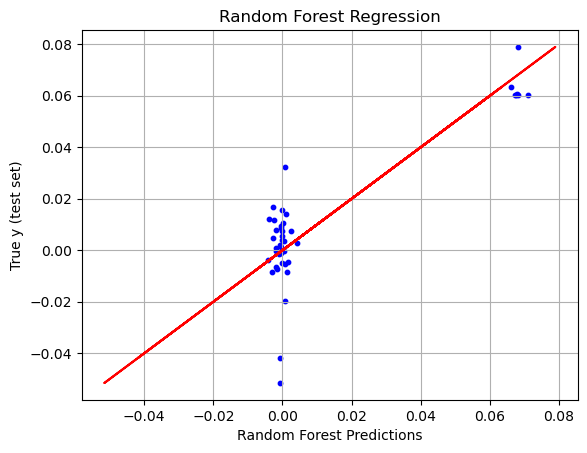

RMSE from Random Forest: 0.014


In [57]:

# === Random Forest Regressor ===
rfm = RandomForestRegressor(
    n_estimators=100,      # number of trees
    random_state=88,
    n_jobs=-1              # use all CPU cores for training
)

rfm.fit(Xtrain, ytrain)           # Train on training set
ypredRF = rfm.predict(Xtest)      # Predict on test set

# === Plot Predictions ===
plt.scatter(ypredRF, ytest, c='blue', s=10)
plt.plot(ytest, ytest, c='red')  # reference y=x line
plt.xlabel('Random Forest Predictions')
plt.ylabel('True y (test set)')
plt.title('Random Forest Regression')
plt.grid(True)
plt.savefig("RandomForest_n100.png", dpi=300)
plt.show()

# === RMSE ===
print('RMSE from Random Forest:', myrmse(ytest, ypredRF))


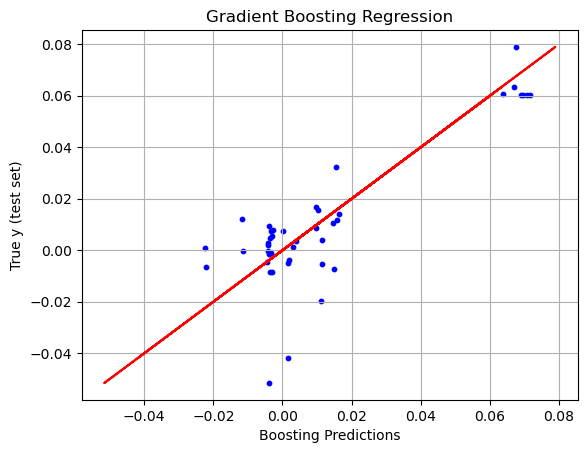

Boosting RMSE: 0.015


In [43]:

# === Boosting Model ===
gbm = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=10,
    random_state=88
)

gbm.fit(Xtrain, ytrain)           # Fit on training set
ypredB = gbm.predict(Xtest)       # Predict on test set

# === Plot Predictions ===
plt.scatter(ypredB, ytest, c='blue', s=10)
plt.plot(ytest, ytest, c='red')   # reference line y=x
plt.xlabel('Boosting Predictions')
plt.ylabel('True y (test set)')
plt.title('Gradient Boosting Regression')
plt.grid(True)
plt.savefig("Boosting_n500_e1_d10.png", dpi=300)
plt.show()

# === RMSE ===
print(f'Boosting RMSE: {myrmse(ypredB, ytest)}')


Epoch 0, Loss: 0.17971
Epoch 50, Loss: 0.00499
Epoch 100, Loss: 0.01665
Epoch 150, Loss: 0.00342
Epoch 200, Loss: 0.00177
Epoch 250, Loss: 0.00043
Epoch 300, Loss: 0.00027
Epoch 350, Loss: 0.00780
Epoch 400, Loss: 0.01099
Epoch 450, Loss: 0.00086
Epoch 500, Loss: 0.00004
Epoch 550, Loss: 0.00029
Epoch 600, Loss: 0.00003
Epoch 650, Loss: 0.00007
Epoch 700, Loss: 0.00003
Epoch 750, Loss: 0.00004
Epoch 800, Loss: 0.00001
Epoch 850, Loss: 0.00022
Epoch 900, Loss: 0.00081
Epoch 950, Loss: 0.00357


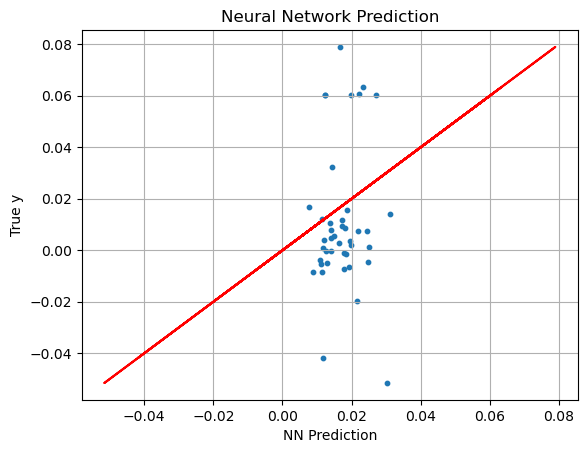

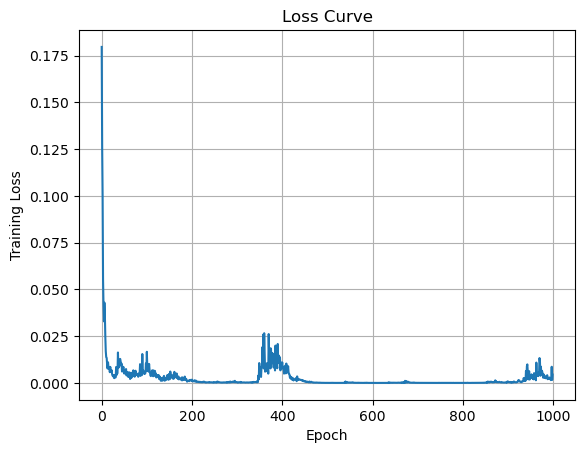

Neural Net RMSE: 0.028


NameError: name 'ypredNN' is not defined

In [49]:
# === Normalize X and y ===
sc = StandardScaler()
xtr = sc.fit_transform(Xtrain)
xte = sc.transform(Xtest)

scy = StandardScaler()
ytr = scy.fit_transform(ytrain.reshape(-1, 1))
yte = scy.transform(ytest.reshape(-1, 1))

# === Convert to Tensors ===
xtr = torch.from_numpy(xtr.astype('float32'))
xte = torch.from_numpy(xte.astype('float32'))
ytr = torch.from_numpy(ytr.astype('float32'))
yte = torch.from_numpy(yte.astype('float32'))

# === Dataset Class ===
class DF(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# === DataLoader ===
train_ds = DF(xtr, ytr)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

# === Neural Network Model ===
class SLNN(nn.Module):
    def __init__(self, ninputs, nunits=64):
        super(SLNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(ninputs, nunits),
            nn.ReLU(),
            nn.Linear(nunits, nunits),
            nn.ReLU(),
            nn.Linear(nunits, 1)
        )
    def forward(self, x):
        return self.net(x)

# === Initialize model ===
model = SLNN(ninputs=X.shape[1], nunits=64)

# === Loss and Optimizer ===
learning_rate = 1e-3
l2par = 1e-4
#l2par = 0
loss_fn = nn.HuberLoss() #nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2par)

# === Training Loop ===
epochs = 1000
loss_vals = np.zeros(epochs)

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_fn(model(dataloader.dataset.x), dataloader.dataset.y).item()

for t in range(epochs):
    loss_vals[t] = train_loop(train_dl, model, loss_fn, optimizer)
    if np.isnan(loss_vals[t]):
        print(f"Epoch {t}: NaN loss detected — stopping training.")
        break
    if t % 50 == 0:
        print(f"Epoch {t}, Loss: {loss_vals[t]:.5f}")

# === Prediction on Test Set ===
model.eval()
with torch.no_grad():
    ypredN = model(xte).numpy()
    ypredN = scy.inverse_transform(ypredN).flatten()

# === Plot Results ===
plt.scatter(ypredN, ytest, s=10)
plt.plot(ytest, ytest, c='red')
plt.xlabel('NN Prediction')
plt.ylabel('True y')
plt.title('Neural Network Prediction')
plt.grid(True)
plt.savefig('used_NEURALNET', dpi=300)
plt.show()

# === Plot Loss Curve ===
plt.plot(loss_vals)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve")
plt.grid(True)
plt.savefig("nn_loss_curve.png", dpi=300)
plt.show()

# === RMSE ===
print(f'Neural Net RMSE: {myrmse(ypredN, ytest)}')

ypredDF_NN = pd.DataFrame({'ytest':ytest,'ypredN':ypredN})
print(ypredDF_NN.corr())

import seaborn as sns
sns.pairplot(ypredDF_NN,diag_kind='kde',height=3)
plt.savefig("NeuralNet_comparison.png", dpi=300)




###with PCA




# === PCA Dimensionality Reduction ===
pca = PCA(n_components=50)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

# === Normalize X and y ===
sc = StandardScaler()
xtr = sc.fit_transform(Xtrain_pca)
xte = sc.transform(Xtest_pca)

scy = StandardScaler()
ytr = scy.fit_transform(ytrain.reshape(-1, 1))
yte = scy.transform(ytest.reshape(-1, 1))

# === Convert to Tensors ===
xtr = torch.from_numpy(xtr.astype('float32'))
xte = torch.from_numpy(xte.astype('float32'))
ytr = torch.from_numpy(ytr.astype('float32'))
yte = torch.from_numpy(yte.astype('float32'))

# === Dataset Class ===
class DF(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# === DataLoader ===
train_ds = DF(xtr, ytr)
train_dl = DataLoader(train_ds, batch_size=20, shuffle=True)

# === Neural Network Model with Dropout ===
class SLNN(nn.Module):
    def __init__(self, ninputs, nunits=128):
        super(SLNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(ninputs, nunits),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(nunits, nunits),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(nunits, 1)
        )
    def forward(self, x):
        return self.net(x)

# === Initialize model ===
model = SLNN(ninputs=xtr.shape[1], nunits=128)

# === Loss and Optimizer ===
learning_rate = 1e-3
l2par = 1e-4
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2par)

# === Training Loop ===
epochs = 500
loss_vals = np.zeros(epochs)

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_fn(model(dataloader.dataset.x), dataloader.dataset.y).item()

for t in range(epochs):
    loss_vals[t] = train_loop(train_dl, model, loss_fn, optimizer)
    if np.isnan(loss_vals[t]):
        print(f"Epoch {t}: NaN loss detected — stopping training.")
        break
    if t % 50 == 0:
        print(f"Epoch {t}, Loss: {loss_vals[t]:.5f}")

# === Prediction on Test Set ===
model.eval()
with torch.no_grad():
    ypredN = model(xte).numpy()
    ypredN = scy.inverse_transform(ypredN).flatten()

# === Plot Prediction Results ===
plt.scatter(ypredN, ytest, s=10)
plt.plot(ytest, ytest, c='red')
plt.xlabel('NN Prediction')
plt.ylabel('True y')
plt.title('Neural Network Prediction (PCA reduced input)')
plt.grid(True)
plt.savefig('neural_net_pca_prediction_512.png', dpi=300)
plt.show()

# === RMSE ===
print(f'Neural Net RMSE: {myrmse(ypredN, ytest)}')

# === Plot Loss Curve ===
plt.plot(loss_vals)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve")
plt.grid(True)
plt.savefig("nn_loss_curve.png", dpi=300)
plt.show()


             ytest   ypredLR  ypredKNN    ypredT   ypredRF    ypredB    ypredN
ytest     1.000000 -0.029577 -0.182913  0.813814  0.861093  0.850423  0.055931
ypredLR  -0.029577  1.000000  0.221737  0.134208  0.109093  0.094199  0.899530
ypredKNN -0.182913  0.221737  1.000000 -0.100692 -0.130326 -0.140571  0.093828
ypredT    0.813814  0.134208 -0.100692  1.000000  0.933339  0.984052  0.217792
ypredRF   0.861093  0.109093 -0.130326  0.933339  1.000000  0.943787  0.171938
ypredB    0.850423  0.094199 -0.140571  0.984052  0.943787  1.000000  0.169531
ypredN    0.055931  0.899530  0.093828  0.217792  0.171938  0.169531  1.000000


rmse:lr, knn, tree, rf, gb, nn: 0.03 0.029 0.017 0.014 0.015 0.028


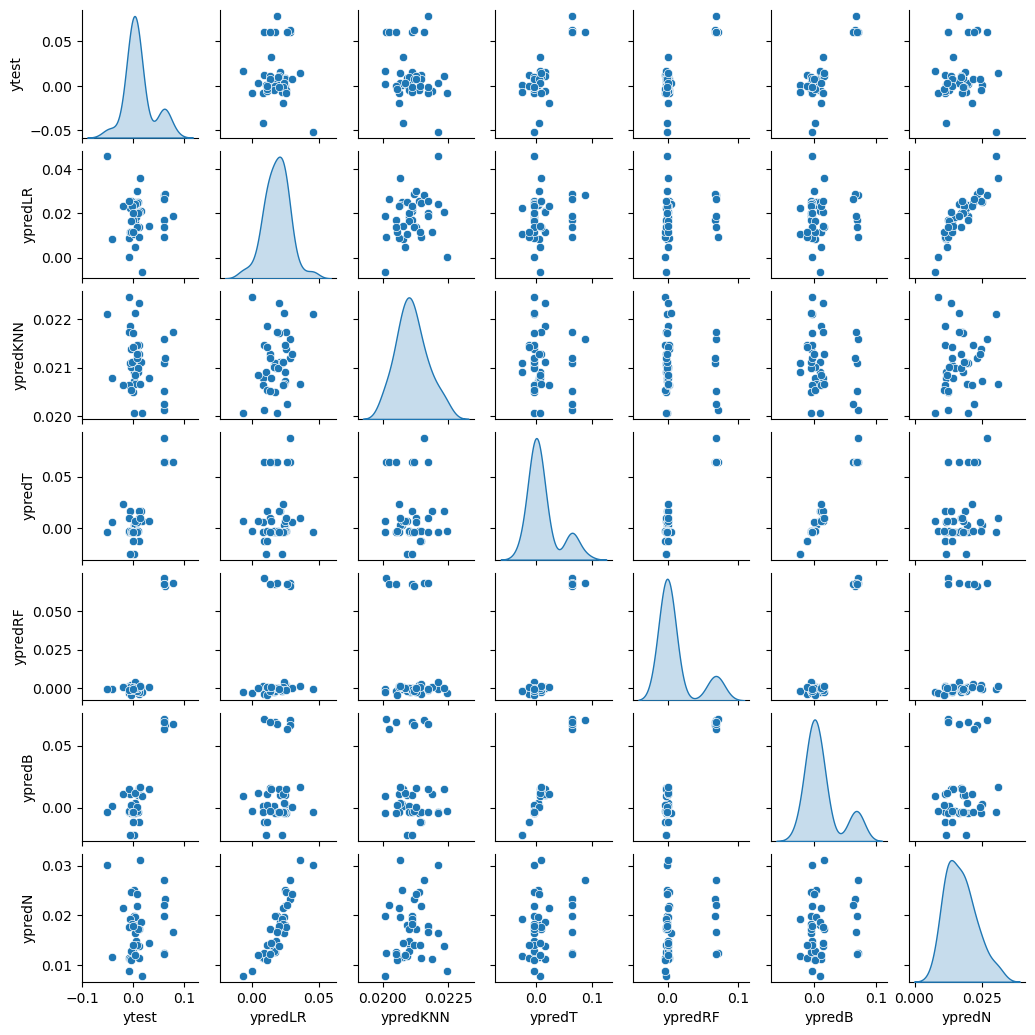

In [61]:
## compare boosting to rf
ypredDF = pd.DataFrame({'ytest':ytest,'ypredLR':ypredLR,'ypredKNN':ypredKNN,'ypredT':ypredT,'ypredRF':ypredRF,'ypredB':ypredB,'ypredN':ypredN})
print(ypredDF.corr())


print('\n\nrmse:lr, knn, tree, rf, gb, nn:', myrmse(ytest,ypredLR),myrmse(ytest,ypredKNN),myrmse(ypredT,ytest),myrmse(ytest,ypredRF),myrmse(ytest,ypredB),myrmse(ytest,ypredN))

import seaborn as sns
sns.pairplot(ypredDF,diag_kind='kde',height=1.5)
# Save the figure
plt.savefig('allcompared_project', dpi=300)